In [6]:
import json

scientific_articles = []
with open('json/related-articles_pro-science.json', 'r') as storage:
    info = json.loads(storage.read())
    for article in info:
        scientific_articles.append(article[1])

conspiracy_articles = [] 
with open('json/related-articles_conspiracy.json', 'r') as storage:
    info = json.loads(storage.read())
    for article in info:
        conspiracy_articles.append(article[1])

# get the same amount, or just trim off the excess
min_len = min(len(scientific_articles), len(conspiracy_articles))

scientific_articles = scientific_articles[:min_len]
conspiracy_articles = conspiracy_articles[:min_len]

print(len(scientific_articles), len(conspiracy_articles))

print(scientific_articles)

8 8
['On October 6, a Qantas crew led by Captain Alex Passerini made the airline’s longest ever commercial passenger flight. Flight QF14 took off from Buenos Aires, Argentina and flew nonstop to the north coast of Australia, landing after 17 hours and 25 minutes and covering 9,334 miles. The Boeing 787-9 Great Barrier Reef carried four pilots, 17 crew, and 107 Australian passengers repatriated from South America due to the COVID pandemic. “There were some truly spectacular views as we tracked across Antarctica, which was an extra bonus for our passengers, who were very glad to be coming home,” said Passerini. The flight was about 325 miles longer than the airline’s previous longest trip, a regularly scheduled flight from Perth to London, which has been paused for the pandemic.\n\nThough impressive, the October 6 flight is not the world’s longest. That honor goes to Singapore Airlines for service between New York and Singapore, a distance of 9,537 miles. Air Tahiti has an even longer no

In [7]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from dateutil.parser import parse
from nltk.stem import WordNetLemmatizer
from article_finder import ArticleFinder
import matplotlib.pyplot as plt

import string
import nltk

class BagOfWords:
    def __init__(self, tokenized_paragraph: list, is_positive: bool):
        self.sentences = tokenized_paragraph
        self.is_positive = is_positive

    def tokenize(self):
        self.words = []
        for sentence in self.sentences:
            for word in word_tokenize(sentence):
                self.words.append(word)

    def to_lower_case(self):
        for i in range(len(self.words)):
            self.words[i] = self.words[i].lower()

    def clean_data(self):
        noise = ['...', "n't"]
        def is_time_or_date(word):  
            try:
                parsed = parse(word)
                return True
            except:
                return False

        def is_link(word):
            for suffix in ArticleFinder.suffixes:
                if suffix in word:
                    return True
            return False

        # rn = set()

        for i in range(len(self.words)-1, -1, -1):
            if len(self.words[i]) <= 2 or self.words[i].isnumeric() or is_time_or_date(self.words[i]) or self.words[i] in noise or is_link(self.words[i]):
                self.words.pop(i)
                continue
        
            # shave punctation off of beginnings and from the end
            start_ind, end_ind = -1, -1
            for j in range(len(self.words[i])):
                if self.words[i][j] in string.ascii_lowercase or self.words[i][j].isnumeric():
                    start_ind = j
                    break
            for j in range(len(self.words[i])-1, -1, -1):
                if self.words[i][j] in string.ascii_lowercase or self.words[i][j].isnumeric():
                    end_ind = j
                    break

            if (start_ind == 0 and end_ind == len(self.words[i])-1) or start_ind >= end_ind:
                continue

            self.words[i] = self.words[i][start_ind:end_ind+1]
            # rn.add((self.words[i], self.words[i][start_ind:end_ind+1]))

    def remove_stop_words(self):
        for i in range(len(self.words)-1, -1, -1):
            if self.words[i] in stopwords.words('english'):
                self.words.pop(i)  

    def normalize_words(self):
        def get_part_of_speech(provided_word):
            _, part_of_speech = nltk.pos_tag([provided_word])[0]
            if 'NN' in part_of_speech:
                return 'n'
            if 'VB' in part_of_speech:
                return 'v'
            if 'JJ' in part_of_speech:
                return 'a'
            if 'RB' in part_of_speech:
                return 'r'
            return 'n'

        lemmatizer = WordNetLemmatizer()
        for i in range(len(self.words)):
            self.words[i] = lemmatizer.lemmatize(self.words[i], get_part_of_speech(self.words[i]))

    def create_frequency_chart(self):
        self.freqChart = dict()

        for word in self.words:
            if word not in self.freqChart:
                self.freqChart[word] = 1
            else:
                self.freqChart[word] += 1

        # sorting in ascending order by value
        self.freqChart = {word: self.freqChart[word] for word in sorted(self.freqChart, key=self.freqChart.get, reverse=True)}

    def plot_frequency_chart(self):
        words = list(self.freqChart.keys())[:100]
        frequencies = list(self.freqChart.values())[:100]

        plt.figure(figsize=(20, 5))
        plt.margins(x=0, tight=True)
        plt.bar(words, frequencies, color ='green')

        # setting title and labels
        plt.xlabel("Distinct Words")
        plt.tick_params(axis='x', which='major', labelsize=9)
        plt.xticks(rotation = 90)

        plt.ylabel(f"Frequency of Words in {self.is_positive}")
        plt.title("Frequency Chart")

        # loading the plot
        plt.show()

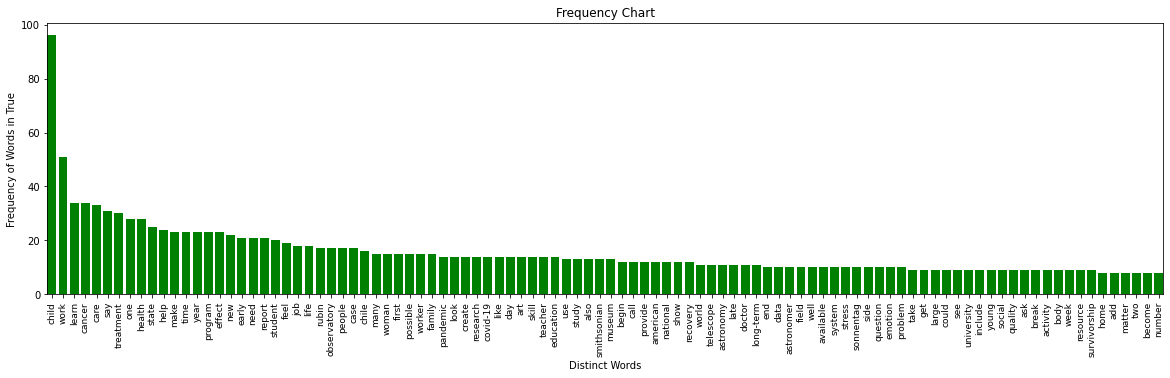

In [8]:
a = BagOfWords(scientific_articles, True)

a.tokenize()
a.to_lower_case()
a.clean_data()
a.remove_stop_words()
a.normalize_words() # todo: improve part of speech performance
a.create_frequency_chart()
a.plot_frequency_chart()

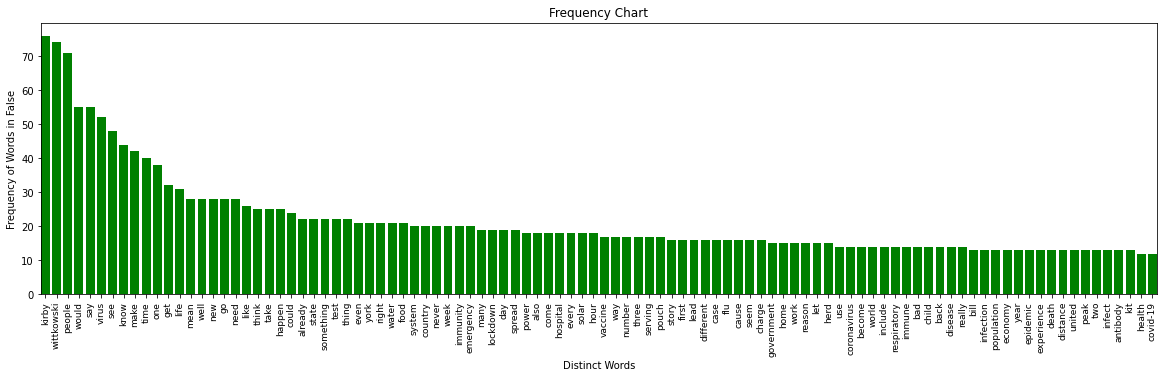

In [10]:
b = BagOfWords(conspiracy_articles, False)

# assuming rn that everything is clean because of testing on 'a', will test later
b.tokenize()
b.to_lower_case()
b.clean_data()
b.remove_stop_words()
b.normalize_words() # todo: improve part of speech performance
b.create_frequency_chart()
b.plot_frequency_chart()

In [29]:
# count the number of times these words occur in each of the articles 




In [34]:
# determine common words between the two sets of words
common_words = dict()
for word, count in a.freqChart.items():
    if word in b.freqChart:
        diff_count = count - b.freqChart[word]
        common_words[word] = diff_count/(count + b.freqChart[word])

# remove all with count 0 
# common_words = dict(filter(lambda elem: elem[1] != 0, common_words.items()))

# sorting the dictionary in descending order
common_words = {word: common_words[word] for word in sorted(common_words, key=common_words.get, reverse=True)}

In [35]:
common_words

{'care': 0.9411764705882353,
 'treatment': 0.9354838709677419,
 'learn': 0.8888888888888888,
 'teacher': 0.8666666666666667,
 'american': 0.8461538461538461,
 'national': 0.8461538461538461,
 'recovery': 0.8461538461538461,
 'long-term': 0.8333333333333334,
 'write': 0.7777777777777778,
 'family': 0.7647058823529411,
 'early': 0.75,
 'trip': 0.75,
 'community': 0.75,
 'development': 0.75,
 'child': 0.7454545454545455,
 'job': 0.7142857142857143,
 'universe': 0.7142857142857143,
 'note': 0.7142857142857143,
 'tend': 0.7142857142857143,
 'healthy': 0.7142857142857143,
 'five': 0.7142857142857143,
 'age': 0.7142857142857143,
 'practice': 0.7142857142857143,
 'summary': 0.7142857142857143,
 'available': 0.6666666666666666,
 'service': 0.6666666666666666,
 'behavior': 0.6666666666666666,
 'visit': 0.6666666666666666,
 'research': 0.6470588235294118,
 'quality': 0.6363636363636364,
 'body': 0.6363636363636364,
 'report': 0.6153846153846154,
 'help': 0.6,
 'sky': 0.6,
 'rise': 0.6,
 'psycholo

In [38]:
print(len(common_words))
print(sum(y > 0 for _, y in common_words.items()))
print(sum(y < 0 for _, y in common_words.items()))

679
187
330


In [32]:
# plot a graph containing words on either side
x_axis, y_axis = [], []
for word, value in common_words.items():
    x_axis.append(word)
    y_axis.append(value)

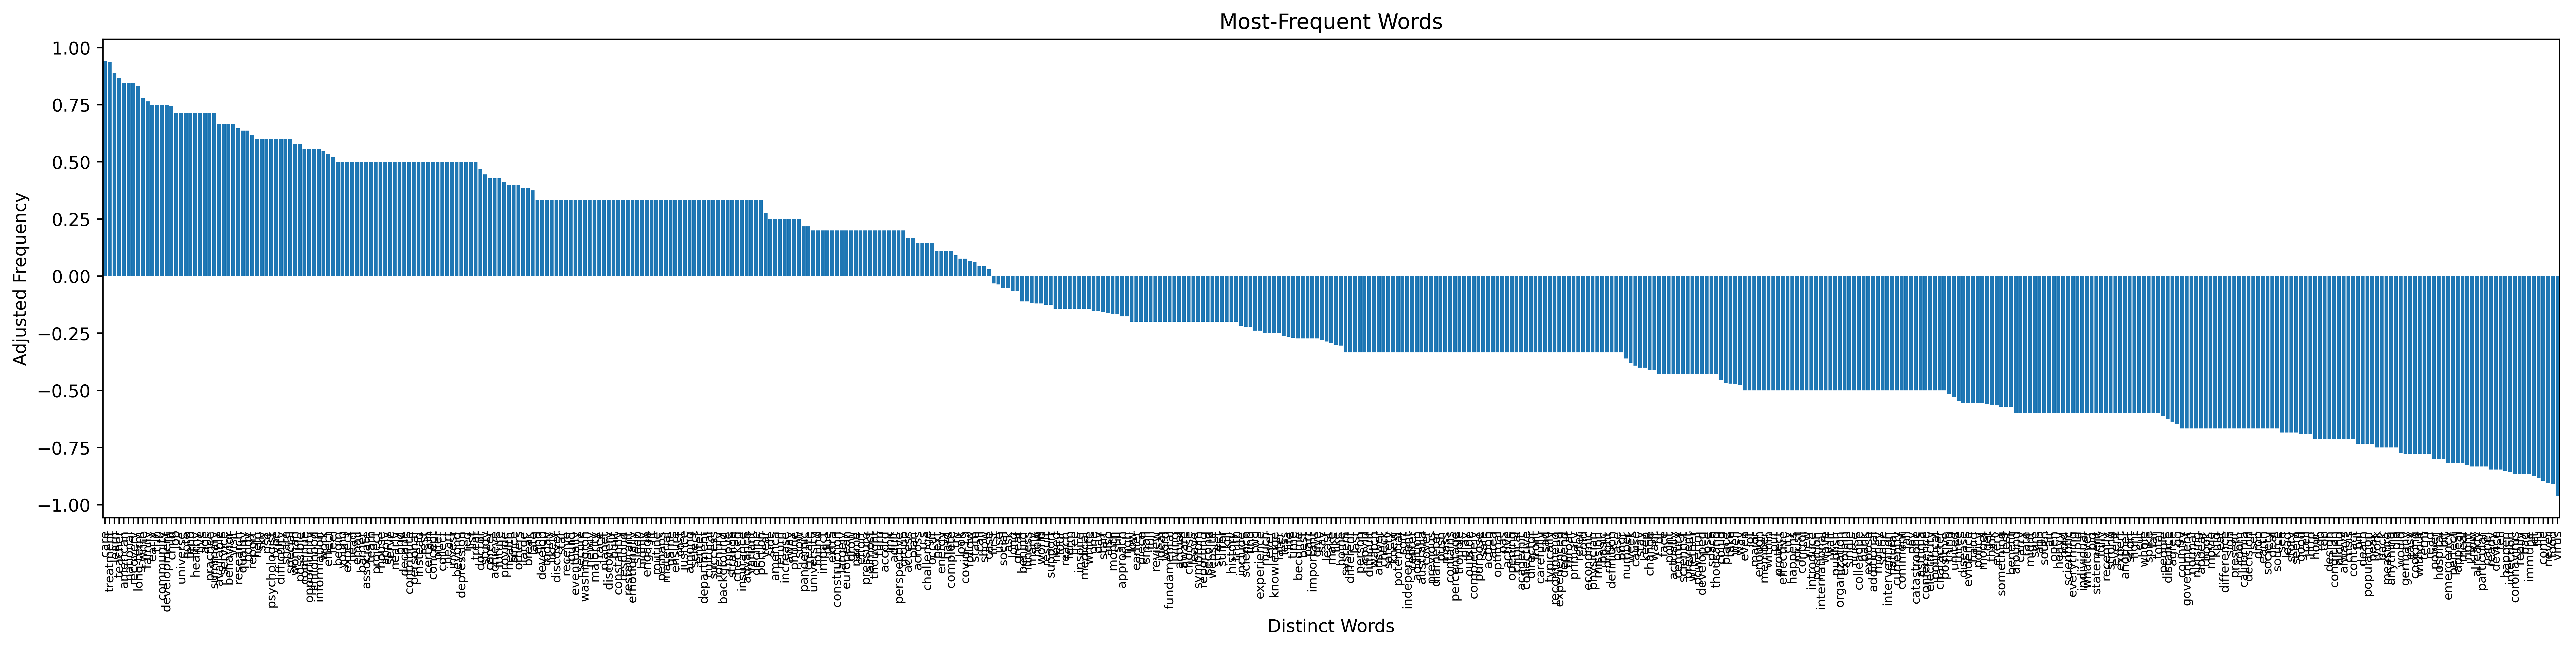

In [33]:
plt.figure(figsize=(25, 5), dpi=500)
plt.margins(x=0, tight=True)
plt.xlabel("Distinct Words")
plt.ylabel("Adjusted Frequency")
plt.title("Most-Frequent Words")
plt.bar(x_axis, y_axis)
plt.tick_params(axis='x', which='major', labelsize=7)
plt.xticks(rotation = 90)
plt.show()

In [23]:
# extract 20 most common words
sorted_words = []
for key, value in common_words.items():
    sorted_words.append([abs(value), key])
sorted_words.sort(reverse=True)

# take 20 with highest magnitudes  
relevant_words = sorted_words[:40]

# give the sign back
for word in relevant_words:
    word[0] = common_words[word[1]]

relevant_words.sort()

In [24]:
relevant_words

[[-0.9622641509433962, 'virus'],
 [-0.9090909090909091, 'food'],
 [-0.9047619047619048, 'never'],
 [-0.8947368421052632, 'come'],
 [-0.8823529411764706, 'flu'],
 [-0.875, 'let'],
 [-0.8666666666666667, 'bad'],
 [-0.8666666666666667, 'coronavirus'],
 [-0.8666666666666667, 'immune'],
 [-0.8666666666666667, 'really'],
 [-0.8571428571428571, 'infection'],
 [-0.8518518518518519, 'happen'],
 [-0.8461538461538461, 'device'],
 [-0.8461538461538461, 'ready'],
 [-0.8461538461538461, 'tell'],
 [-0.8333333333333334, 'already'],
 [-0.8333333333333334, 'know'],
 [-0.8333333333333334, 'panel'],
 [-0.8333333333333334, 'particular'],
 [-0.8260869565217391, 'right'],
 [-0.8181818181818182, 'appeal'],
 [-0.8181818181818182, 'emergency'],
 [-0.8181818181818182, 'meal'],
 [-0.8181818181818182, 'perfect'],
 [-0.8, 'bit'],
 [-0.8, 'hospital'],
 [-0.8, 'power'],
 [-0.7777777777777778, 'germany'],
 [-0.7777777777777778, 'read'],
 [-0.7777777777777778, 'term'],
 [-0.7777777777777778, 'without'],
 [0.77777777777

In [25]:
positive_cnt = sum(x[0] > 0 for x in relevant_words)

In [26]:
positive_cnt

9